## Task 3: Super-Resolution using Random Fourier Features

In this notebook, we perform **image super-resolution** using **Random Fourier Features (RFF)** combined with a **linear regression model**. The goal is to upscale a low-resolution 200x200 image to a higher-resolution 400x400 image and evaluate the reconstruction quality using **RMSE** and **PSNR**.

1. **Image Loading and Preprocessing**:
   - We load a high-resolution image and normalize its pixel values using `MinMaxScaler` to scale them between 0 and 1.
   
2. **Image Resizing**:
   - The high-resolution image (400x400) is resized to 200x200 using `cv2.resize`, which serves as the input for the super-resolution model.

3. **Coordinate Mapping**:
   - We generate pixel coordinate grids (`X_200` and `X_400`) for both the 200x200 and 400x400 images, which will be used as inputs for learning and reconstructing pixel values.

4. **Random Fourier Features (RFF) Generation**:
   - We use RFF to transform the coordinate grids into a higher-dimensional space, approximating the **RBF kernel** for efficient non-linear transformations. The number of RFF features is set to 20,000 based on memory constraints.

5. **Training the Linear Model**:
   - A **linear regression model** is trained on the RFF-transformed coordinates of the 200x200 image (`X_rff_200`) and the corresponding pixel values to learn the mapping to RGB values.

6. **Super-resolution Inference**:
   - After training, the model is used to predict pixel values for the 400x400 image (`X_rff_400`), effectively upscaling the image.

7. **Reconstruction Visualization**:
   - We visualize the reconstructed high-resolution image and compare it to the original image to demonstrate the super-resolution capability.

8. **Reconstruction Metrics**:
   - We evaluate the quality of the reconstructed image using:
     - **RMSE (Root Mean Square Error)**: Measures the average pixel-wise difference between the original and reconstructed image.
     - **PSNR (Peak Signal-to-Noise Ratio)**: Provides a measure of the reconstruction quality, where higher values indicate better fidelity.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.kernel_approximation import RBFSampler
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

### Loading original image

We load the image using `torchvision.io.read_image`, which reads it as a tensor in the format `(C, H, W)`. To display the image using `matplotlib`, we rearrange it to `(H, W, C)` using `einops.rearrange`, since `plt.imshow` expects the channel dimension last. This lets us inspect the original image before further processing.


torch.Size([3, 1599, 899])


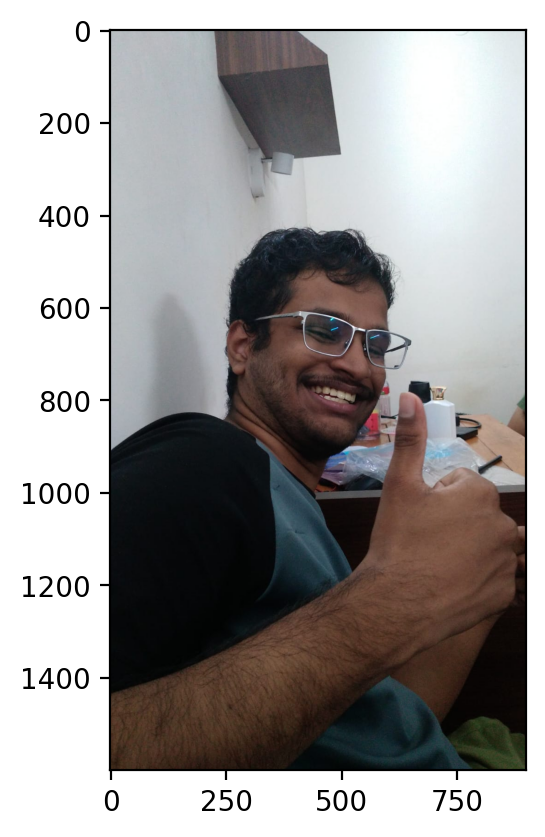

In [2]:
img = torchvision.io.read_image("sample_images/bro.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

### Image Preprocessing: Normalization

We normalize the pixel values using `MinMaxScaler` to scale the image data between 0 and 1, preparing it for the RFF transformation and model training.


In [3]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
print("Scaled image shape:", img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

Scaled image shape: (3, 1599, 899)


tensor([[[0.7098, 0.7333, 0.7490,  ..., 0.8667, 0.8784, 0.8824],
         [0.7216, 0.7333, 0.7333,  ..., 0.8667, 0.8784, 0.8824],
         [0.7333, 0.7255, 0.7098,  ..., 0.8627, 0.8706, 0.8745],
         ...,
         [0.2706, 0.2745, 0.2745,  ..., 0.2745, 0.2745, 0.2627],
         [0.2706, 0.2784, 0.2824,  ..., 0.2588, 0.2549, 0.2510],
         [0.2706, 0.2824, 0.2902,  ..., 0.2627, 0.2510, 0.2510]],

        [[0.7255, 0.7490, 0.7725,  ..., 0.8824, 0.8824, 0.8863],
         [0.7373, 0.7490, 0.7569,  ..., 0.8824, 0.8824, 0.8863],
         [0.7490, 0.7412, 0.7333,  ..., 0.8824, 0.8863, 0.8902],
         ...,
         [0.1804, 0.1843, 0.1843,  ..., 0.3176, 0.3137, 0.3059],
         [0.1804, 0.1882, 0.1922,  ..., 0.2941, 0.2941, 0.2902],
         [0.1804, 0.1922, 0.2000,  ..., 0.2902, 0.2902, 0.2902]],

        [[0.7294, 0.7529, 0.7725,  ..., 0.8941, 0.8980, 0.9020],
         [0.7412, 0.7529, 0.7569,  ..., 0.8941, 0.8980, 0.9020],
         [0.7529, 0.7451, 0.7333,  ..., 0.8941, 0.8980, 0.

### Cropping the image
- We crop the image to focus on a 400x400 section of the image

In [4]:
img400 = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 250, 400, 400)
img400 = img400.to(device)
img400.shape

torch.Size([3, 400, 400])

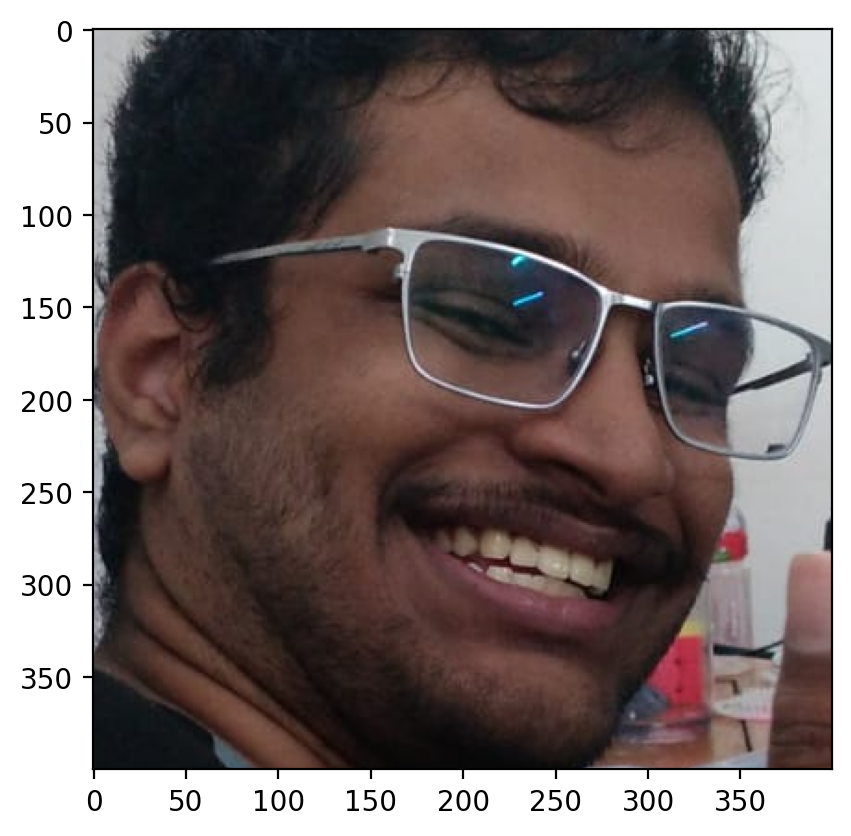

In [5]:
plt.imshow(rearrange(img400, 'c h w -> h w c').cpu().numpy())

### Resizing the Image to 200x200 for Model Input

The 400x400 image is resized to 200x200, which will serve as the input to the super-resolution model.


In [6]:
import cv2
import torch

# Print shape of the original image
print(f"Original image shape: {img400.shape}")  # (C, H, W) format

# Convert the PyTorch tensor to NumPy, move to CPU, and transpose to (H, W, C)
img400_np = img400.permute(1, 2, 0).cpu().numpy()

# Resize the NumPy array from 400x400 to 200x200
img200_np = cv2.resize(img400_np, (200, 200))

# Convert the resized image back to a PyTorch tensor and move to the device
img200 = torch.tensor(img200_np).permute(2, 0, 1).to(device)  # Back to (C, H, W)

# Print shape of the resized image
print(f"Resized image shape: {img200.shape}")


Original image shape: torch.Size([3, 400, 400])
Resized image shape: torch.Size([3, 200, 200])


### Visualizing images

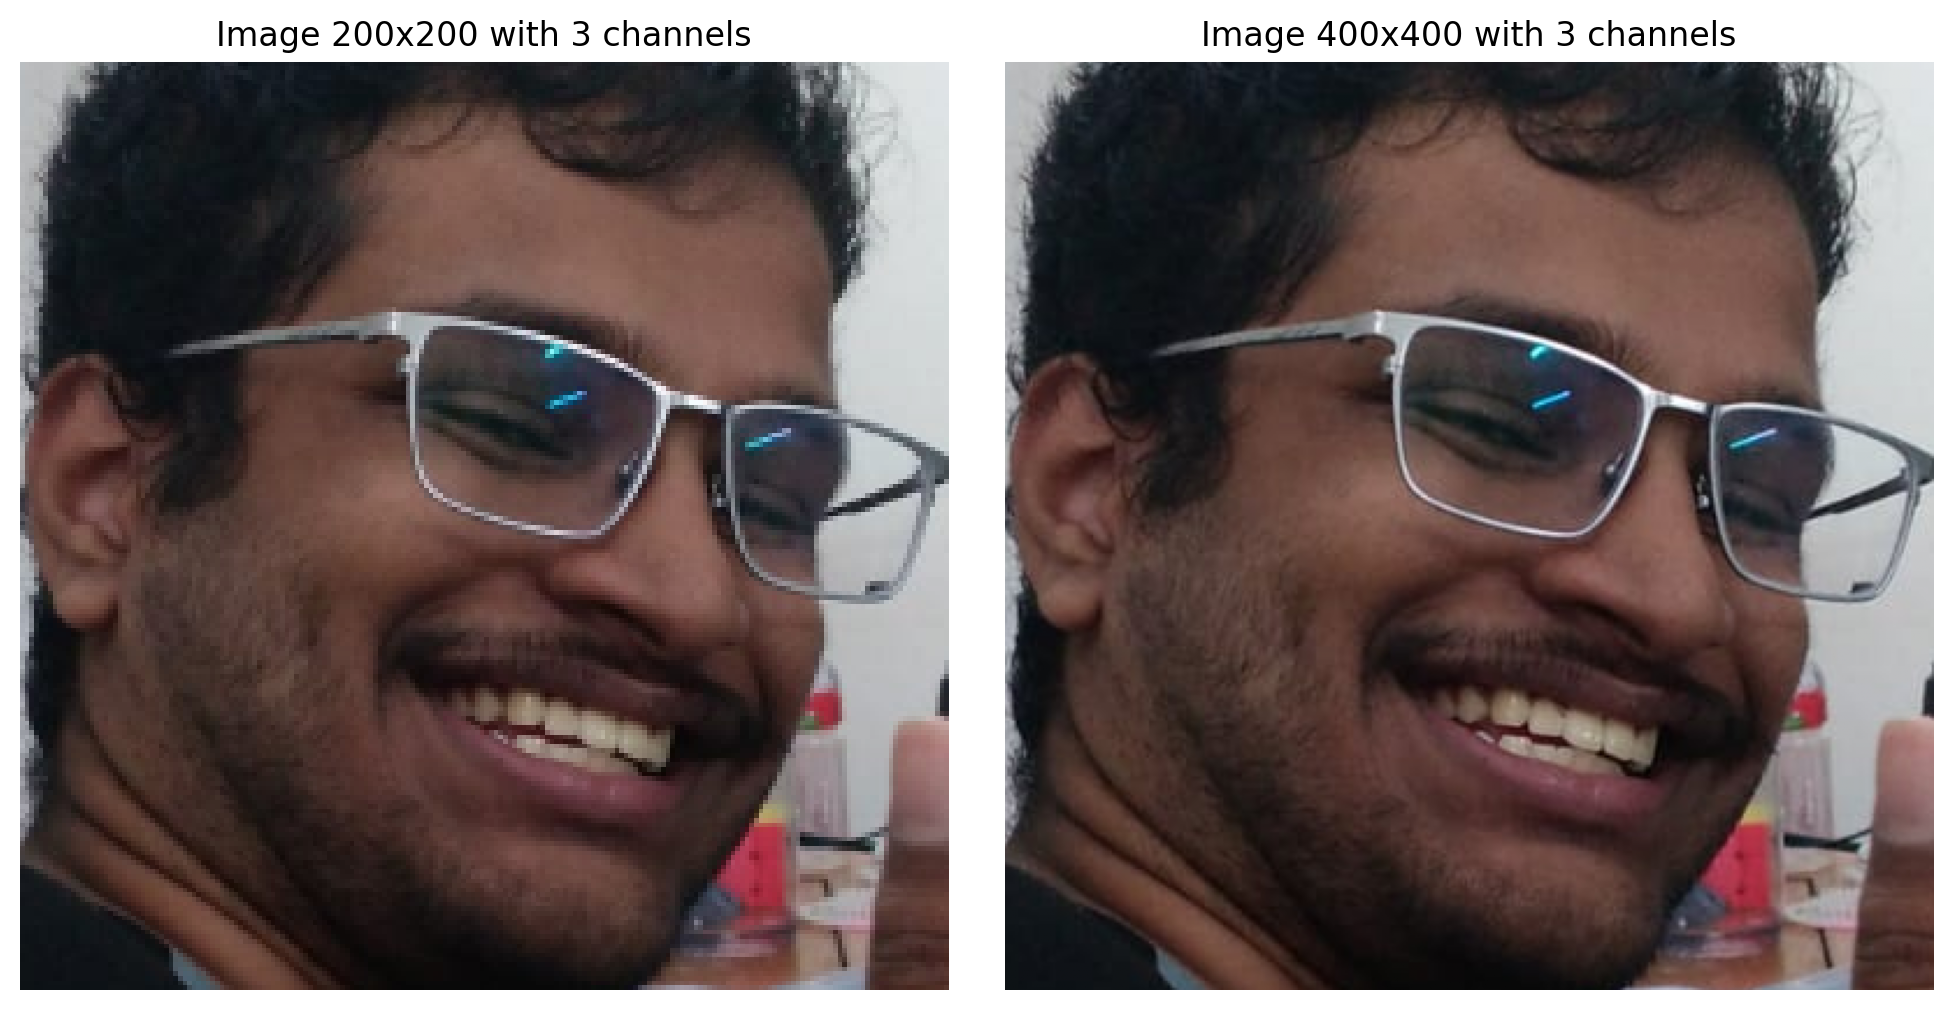

In [7]:
import matplotlib.pyplot as plt
from einops import rearrange

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display img200 (200x200)
axes[0].imshow(rearrange(img200, 'c h w -> h w c').cpu().numpy())
axes[0].set_title("Image 200x200 with 3 channels")
axes[0].axis('off')  # Turn off the axis

# Display img400 (400x400)
axes[1].imshow(rearrange(img400, 'c h w -> h w c').cpu().numpy())
axes[1].set_title("Image 400x400 with 3 channels")
axes[1].axis('off')  # Turn off the axis

# Adjust layout
plt.tight_layout()
plt.show()


### The `create_coordinate_map` Function

1. **Input**: Takes an image tensor of shape `(num_channels, height, width)` and a `scale` factor to control the granularity of the coordinate grid.
   
2. **2D Coordinates (`X`)**: Creates a tensor of scaled pixel coordinates `(x, y)` for each pixel in the image, with shape `(scaled_height * scaled_width, 2)`, where `scaled_height` and `scaled_width` are adjusted according to the `scale` factor.
   
3. **Image Reshaping (`Y`, optional)**: If `scale=1`, the image is reshaped into a tensor of pixel values with shape `(height * width, num_channels)`. This ensures that pixel values match the original coordinate grid resolution. For other scale values, only the coordinate grid is returned, as the pixel values would not align with the scaled grid.
   
4. **Output**:
   - If `scale=1`: Returns `X` (coordinates) and `Y` (corresponding pixel values).
   - If `scale ≠ 1`: Returns only `X` (coordinates), allowing each pixel’s position to be represented for tasks like image reconstruction or upsampling.

#### Use Case:

- **Generating Coordinates for `img200`**: This function is used to generate the coordinate map (`X_200`, `Y_200`) for a low-resolution image `img200` with `scale=1`, where both coordinates and pixel values are returned.
  
- **Superresolution for `img400`**: For superresolution, the function generates only the coordinate map `X_400` for the high-resolution image using `scale=2`. Then, using Random Fourier Features (RFF) along with a linear regression model, the pixel values for the higher-resolution `img400` are predicted based on the learned function from `img200`.


In [8]:
import torch
from einops import rearrange

def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    scale: Scaling factor for coordinates. Default is 1 (no scaling).
    
    return: 
        - X: torch.Tensor of shape (scaled_height * scaled_width, 2), the (x, y) coordinates
        - Y (optional): torch.Tensor of shape (height * width, num_channels) if scale == 1
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x, y) coordinates
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to the appropriate device
    X = X.to(device)

    # Only output Y if scale == 1 (matching size)
    if scale == 1:
        Y = rearrange(img, 'c h w -> (h w) c').float()
        return X, Y
    else:
        return X  # Only return the coordinate grid


In [9]:
# Generate X_200, Y_200 for img200 with scale=1
X_200, Y_200 = create_coordinate_map(img200, scale=1)

# Generate X_400 for img200 with scale=2 (we are just interested in the coordinates here)
X_400 = create_coordinate_map(img200, scale=2)

# Output the shapes to verify
print(f"X_200 shape: {X_200.shape}")  # (height * width, 2)
print(f"Y_200 shape: {Y_200.shape}")  # (height * width, num_channels)

print(f"X_400 shape: {X_400.shape}")  # (scaled height * scaled width, 2)

X_200 shape: torch.Size([40000, 2])
Y_200 shape: torch.Size([40000, 3])
X_400 shape: torch.Size([160000, 2])


In [10]:
# Scale X_200
scaler_X_200 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_200.cpu())
X_200_scaled = scaler_X_200.transform(X_200.cpu())  # Scale X_200 between -1 and 1
X_200_scaled = torch.tensor(X_200_scaled).to(device).float()  # Convert back to tensor and move to device

# Scale X_400
scaler_X_400 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(X_400.cpu())
X_400_scaled = scaler_X_400.transform(X_400.cpu())  # Scale X_400 between -1 and 1
X_400_scaled = torch.tensor(X_400_scaled).to(device).float()  # Convert back to tensor and move to device

# Print shapes to verify
print(f"X_200_scaled shape: {X_200_scaled.shape}")
print(f"X_400_scaled shape: {X_400_scaled.shape}")

X_200_scaled shape: torch.Size([40000, 2])
X_400_scaled shape: torch.Size([160000, 2])


### Utility Functions

In [11]:
def create_rff_features(X, num_features, sigma, seed=None):
    """
    Creates RFF features for input X using the RBFSampler.
    
    Parameters:
    - X: torch.Tensor of shape (num_samples, num_features)
    - num_features: Number of random features to generate
    - sigma: Width parameter for the RBF kernel
    - seed: Random seed for reproducibility. 

    Returns:
    - X_transformed: RFF-transformed version of the input X as a torch tensor.
    """
    from sklearn.kernel_approximation import RBFSampler
    
    # Create RBFSampler with fixed random state if seed is provided
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=seed)

    # Convert tensor to numpy and apply the RFF transformation
    X_np = X.cpu().numpy()
    X_transformed = rff.fit_transform(X_np)
    
    # Convert the transformed result back to a PyTorch tensor and move to device
    return torch.tensor(X_transformed, dtype=torch.float32).to(device)


class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

def plot_reconstructed_and_original_image(original_img, reconstructed_image, title=""):
    """
    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_image: torch.Tensor of shape (height, width, num_channels)
    """
    # Plotting the original and reconstructed images side by side
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot the reconstructed image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(reconstructed_image)
    ax0.set_title("Reconstructed Image")
    ax0.axis("off")

    # Plot the original image
    ax1 = plt.subplot(gs[1])
    ax1.imshow(original_img.cpu().permute(1, 2, 0))  # Permute to (H, W, C) for plotting
    ax1.set_title("Original Image")
    ax1.axis("off")

    # Add title and layout adjustments
    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    plt.show()


def generate_reconstructed_image(net, X, height, width, num_channels, device = torch.device("cuda")):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    
    return: torch.Tensor of shape (height, width, num_channels) (the reconstructed image)
    device: str, either 'cpu' or 'cuda'
    """
    # Ensure the model and input are on the same device
    net = net.to(device)
    X = X.to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(X)  # Generate reconstructed image
        outputs = outputs.reshape(height, width, num_channels)  # Reshape to image dimensions
    
    return outputs.cpu()  # Return reconstructed image on CPU for plotting

def print_reconstruction_metrics(original_img, reconstructed_img, title="Reconstruction Metrics"):
    """
    Prints the RMSE and PSNR between the original and reconstructed images.

    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of shape (num_channels, height, width)
    """
    original_img = original_img.permute(1, 2, 0).cpu().numpy()  # (H, W, C)
    reconstructed_img = reconstructed_img.cpu().numpy()

    def calculate_rmse(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        rmse = np.sqrt(mse)
        return rmse

    def calculate_psnr(original, compressed):
        mse = np.mean((original - compressed) ** 2)
        if mse == 0:
            return float('inf')
        max_pixel = np.max(original)
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr
    # Calculate RMSE and PSNR
    rmse = calculate_rmse(original_img, reconstructed_img)
    psnr = calculate_psnr(original_img, reconstructed_img)

    # Print results
    print(f"{title}:")
    print(f"RMSE on predicted v/s ground truth high resolution image: {rmse:.4f}")
    print(f"Peak SNR on predicted v/s ground truth high resolution image: {psnr:.2f} dB")


### Random Fourier Features (RFF)

To approximate the Radial Basis Function (RBF) kernel, Random Fourier Features (RFF) project input data into a higher-dimensional space. The RBF kernel between two points $ \mathbf{x} $ and $ \mathbf{y} $ is defined as:

$$
k(\mathbf{x}, \mathbf{y}) = \exp\left( -\frac{\|\mathbf{x} - \mathbf{y}\|^2}{2\sigma^2} \right)
$$

To approximate this kernel, we use the following transformation:

1. Draw random vectors $ \mathbf{w}_i \in \mathbb{R}^d $ from a normal distribution $ \mathcal{N}(0, \frac{1}{\sigma^2}) $, where $ \sigma $ is the kernel width.
2. Compute the RFF features $ \mathbf{z}(\mathbf{x}) $ for an input $ \mathbf{x} $ as:

$$
\mathbf{z}(\mathbf{x}) = \sqrt{\frac{2}{D}} \left[ \cos(\mathbf{w}_1^\top \mathbf{x} + b_1), \dots, \cos(\mathbf{w}_D^\top \mathbf{x} + b_D) \right]
$$

where $ D $ is the number of random features, and $ b_i $ are drawn uniformly from $ [0, 2\pi] $.

These features $ \mathbf{z}(\mathbf{x}) $ are used as input to the linear model to approximate the RBF kernel in a computationally efficient manner.


### Generating Random Fourier Features (RFF) from Scaled Coordinates

- We generate 20,000 RFF features with a kernel width (sigma) of 0.008 to approximate the RBF kernel. 
- The number of RFF features were determined based on memory limitations, as training with more features would exceed the available memory. The feature count of 20,000 was chosen as a balance between computational efficiency and model performance. The kernel width was set to 0.08 as per the [Instructor's notebook](https://github.com/nipunbatra/ml-teaching/blob/master/notebooks/siren.ipynb) for Image Reconstruction using RFF.
- Consistent features must be generated for both `X_rff_200` and `X_rff_400`, so we use the same seed, number of features, and kernel width for both.


In [12]:
# Create RFF features for X_200 and X_400
X_rff_200 = create_rff_features(X_200_scaled, 20000, 0.008, seed=42)
X_rff_400 = create_rff_features(X_400_scaled, 20000, 0.008, seed=42)
print(X_rff_200.shape)
print(X_rff_400.shape)
# Initialize the LinearModel with input size equal to the number of RFF features
# The output size is 3, corresponding to the RGB channels of the image
net = LinearModel(X_rff_200.shape[1], 3)

# Move the model to the appropriate device (GPU or CPU)
net.to(device)

torch.Size([40000, 20000])
torch.Size([160000, 20000])


LinearModel(
  (linear): Linear(in_features=20000, out_features=3, bias=True)
)

### Training the Linear Regression Model

In [13]:
train(net, 0.005, X_rff_200, Y_200, 2500)

Epoch 0 loss: 0.131937
Epoch 100 loss: 0.018569
Epoch 200 loss: 0.009991
Epoch 300 loss: 0.005603
Epoch 400 loss: 0.003209
Epoch 500 loss: 0.001897
Epoch 600 loss: 0.001189
Epoch 700 loss: 0.000815
Epoch 800 loss: 0.000621
Epoch 900 loss: 0.000522
Epoch 1000 loss: 0.000472
Epoch 1100 loss: 0.000445
Epoch 1200 loss: 0.000431
Epoch 1300 loss: 0.000422
Epoch 1400 loss: 0.000416
Epoch 1500 loss: 0.000412
Epoch 1600 loss: 0.000408
Epoch 1700 loss: 0.000406
Epoch 1800 loss: 0.000403
Epoch 1900 loss: 0.000401
Epoch 2000 loss: 0.000399
Epoch 2100 loss: 0.000397
Epoch 2200 loss: 0.000396
Epoch 2300 loss: 0.000394
Epoch 2400 loss: 0.000393


0.0003919593873433769

### Super-resolution inference

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

# Getting the dimensions of img400
num_channels, height, width = img400.shape # These will be 3, 400, 400

# Generate the super-resolution reconstructed image from the model and X coordinate map of img400
reconstructed_image = generate_reconstructed_image(net, X_rff_400, height, width, num_channels)
print(reconstructed_image.shape)

torch.Size([400, 400, 3])


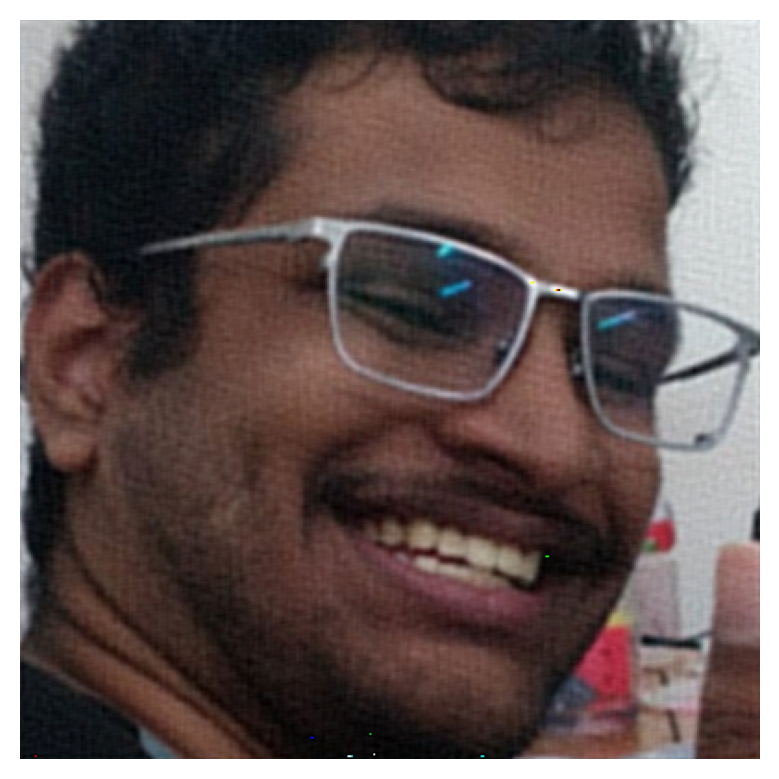

In [15]:
# Convert the reconstructed tensor to numpy array and scale it back to [0, 255]
reconstructed_image_np = (reconstructed_image.cpu().numpy() * 255).astype(np.uint8)

# Display the image using matplotlib
plt.imshow(reconstructed_image_np)
plt.axis('off')  # Hide axes
plt.show()

# Save using PIL
reconstructed_img_pil = Image.fromarray(reconstructed_image_np)
# Save the image
reconstructed_img_pil.save('sample_images/reconstructed_superresolution_bro.png')


### Comparing original and reconstructed super-resolution image

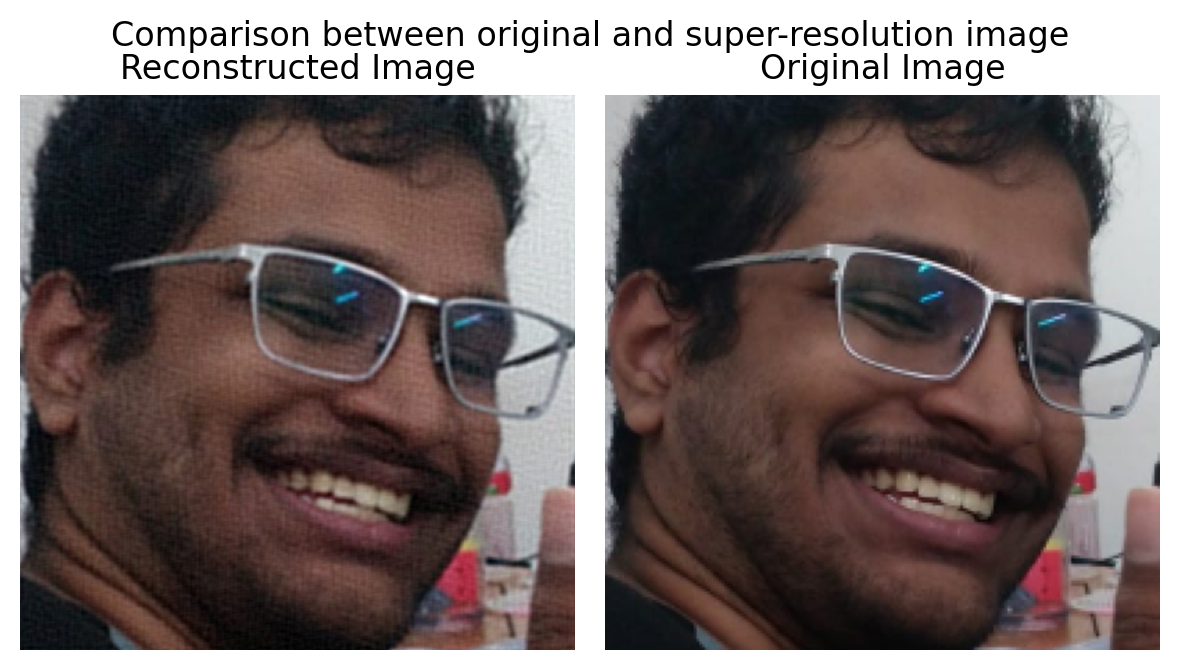

In [16]:
# Plot both the original and reconstructed images
plot_reconstructed_and_original_image(img200, reconstructed_image, title="Comparison between original and super-resolution image")

## Image Reconstruction Metrics

### Here, we have to evaluate these 2 metrics:
- RMSE on predicted v/s ground truth high resolution image
- Peak SNR on predicted v/s ground truth high resolution image

#### 1. **Root Mean Square Error (RMSE)**:
RMSE measures the average difference between the pixel values of the original image and the reconstructed image. It is defined as:

$$
\text{RMSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (I_{\text{original},i} - I_{\text{reconstructed},i})^2}
$$

Where:
- $ N $ is the total number of pixels.
- $ I_{\text{original},i} $ is the pixel value in the original image.
- $ I_{\text{reconstructed},i} $ is the pixel value in the reconstructed image.

A lower RMSE indicates that the reconstructed image is closer to the original.

#### 2. **Peak Signal-to-Noise Ratio (PSNR)**:
PSNR measures the ratio between the maximum possible pixel value and the error (RMSE) between the original and reconstructed images. It is expressed in decibels (dB):

$$
\text{PSNR} = 20 \log_{10} \left( \frac{I_{\text{max}}}{\text{RMSE}} \right)
$$

Where $ I_{\text{max}} $ is the maximum possible pixel value (e.g., 255 for an 8-bit image).

A higher PSNR value indicates better image reconstruction quality. Typically, PSNR values above 30 dB are considered good for most image reconstruction tasks.




In [17]:
print_reconstruction_metrics(img400, reconstructed_image, title="Reconstruction Metrics")

Reconstruction Metrics:
RMSE on predicted v/s ground truth high resolution image: 0.0304
Peak SNR on predicted v/s ground truth high resolution image: 30.34 dB
